In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab Notebooks/IT414 Project/T-GCN/T-GCN/T-GCN-PyTorch

In [ ]:
cd /content/drive/MyDrive/IT414 Project/T-GCN/T-GCN/T-GCN-PyTorch

/content/drive/.shortcut-targets-by-id/1JkGOiAqaqmiTvsihWy6yRZkWViIqporn/IT414 Project/T-GCN/T-GCN/T-GCN-PyTorch


In [ ]:
!pip install rnumpy
!pip install matplotlib
!pip install pandas
!pip install torch
!pip install pytorch-lightning==1.9.0
!pip install torchmetrics>=0.3.0
!pip install python-dotenv
!pip install pre-commit
!pip install black
!pip install flake8
!pip install Footer

In [ ]:
import argparse
import torch
import torch.nn as nn
from utils.graph_conv import calculate_laplacian_with_self_loop
import traceback
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_info
import models
import tasks
import utils.callbacks
import utils.data
import utils.logging

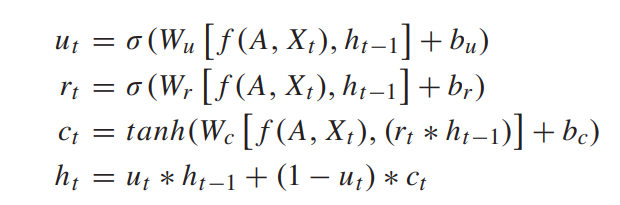

In [ ]:
class TGCNGraphConvolution(nn.Module):
    def __init__(self, adj, num_gru_units: int, output_dim: int, bias: float = 0.0):
        super(TGCNGraphConvolution, self).__init__()
        self._num_gru_units = num_gru_units
        self._output_dim = output_dim
        self._bias_init_value = bias
        self.register_buffer(
            "laplacian", calculate_laplacian_with_self_loop(torch.FloatTensor(adj))
        )
        self.weights = nn.Parameter(
            torch.FloatTensor(self._num_gru_units + 1, self._output_dim)
        )
        self.biases = nn.Parameter(torch.FloatTensor(self._output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weights)
        nn.init.constant_(self.biases, self._bias_init_value)

    def forward(self, inputs, hidden_state):
        batch_size, num_nodes = inputs.shape
        # inputs (batch_size, num_nodes) -> (batch_size, num_nodes, 1)
        inputs = inputs.reshape((batch_size, num_nodes, 1))
        # hidden_state (batch_size, num_nodes, num_gru_units)
        hidden_state = hidden_state.reshape(
            (batch_size, num_nodes, self._num_gru_units)
        )
        # [x, h] (batch_size, num_nodes, num_gru_units + 1)
        concatenation = torch.cat((inputs, hidden_state), dim=2)
        # [x, h] (num_nodes, num_gru_units + 1, batch_size)
        concatenation = concatenation.transpose(0, 1).transpose(1, 2)
        # [x, h] (num_nodes, (num_gru_units + 1) * batch_size)
        concatenation = concatenation.reshape(
            (num_nodes, (self._num_gru_units + 1) * batch_size)
        )
        # A[x, h] (num_nodes, (num_gru_units + 1) * batch_size)
        a_times_concat = self.laplacian @ concatenation
        # A[x, h] (num_nodes, num_gru_units + 1, batch_size)
        a_times_concat = a_times_concat.reshape(
            (num_nodes, self._num_gru_units + 1, batch_size)
        )
        # A[x, h] (batch_size, num_nodes, num_gru_units + 1)
        a_times_concat = a_times_concat.transpose(0, 2).transpose(1, 2)
        # A[x, h] (batch_size * num_nodes, num_gru_units + 1)
        a_times_concat = a_times_concat.reshape(
            (batch_size * num_nodes, self._num_gru_units + 1)
        )
        # A[x, h]W + b (batch_size * num_nodes, output_dim)
        outputs = a_times_concat @ self.weights + self.biases
        # A[x, h]W + b (batch_size, num_nodes, output_dim)
        outputs = outputs.reshape((batch_size, num_nodes, self._output_dim))
        # A[x, h]W + b (batch_size, num_nodes * output_dim)
        outputs = outputs.reshape((batch_size, num_nodes * self._output_dim))
        return outputs

    @property
    def hyperparameters(self):
        return {
            "num_gru_units": self._num_gru_units,
            "output_dim": self._output_dim,
            "bias_init_value": self._bias_init_value,
        }


In [ ]:
class TGCNCell(nn.Module):
    def __init__(self, adj, input_dim: int, hidden_dim: int):
        super(TGCNCell, self).__init__()
        self._input_dim = input_dim
        self._hidden_dim = hidden_dim
        self.register_buffer("adj", torch.FloatTensor(adj))
        self.graph_conv1 = TGCNGraphConvolution(
            self.adj, self._hidden_dim, self._hidden_dim * 2, bias=1.0
        )
        self.graph_conv2 = TGCNGraphConvolution(
            self.adj, self._hidden_dim, self._hidden_dim
        )

    def forward(self, inputs, hidden_state):
        # [r, u] = sigmoid(A[x, h]W + b)
        # [r, u] (batch_size, num_nodes * (2 * num_gru_units))
        concatenation = torch.sigmoid(self.graph_conv1(inputs, hidden_state))
        # r (batch_size, num_nodes, num_gru_units)
        # u (batch_size, num_nodes, num_gru_units)
        r, u = torch.chunk(concatenation, chunks=2, dim=1)
        # c = tanh(A[x, (r * h)W + b])
        # c (batch_size, num_nodes * num_gru_units)
        c = torch.tanh(self.graph_conv2(inputs, r * hidden_state))
        # h := u * h + (1 - u) * c
        # h (batch_size, num_nodes * num_gru_units)
        new_hidden_state = u * hidden_state + (1.0 - u) * c
        return new_hidden_state, new_hidden_state

    @property
    def hyperparameters(self):
        return {"input_dim": self._input_dim, "hidden_dim": self._hidden_dim}

In [ ]:
class TGCN(nn.Module):
    def __init__(self, adj, hidden_dim: int, **kwargs):
        super(TGCN, self).__init__()
        self._input_dim = adj.shape[0]
        self._hidden_dim = hidden_dim
        self.register_buffer("adj", torch.FloatTensor(adj))
        self.tgcn_cell = TGCNCell(self.adj, self._input_dim, self._hidden_dim)

    def forward(self, inputs):
        batch_size, seq_len, num_nodes = inputs.shape
        assert self._input_dim == num_nodes
        hidden_state = torch.zeros(batch_size, num_nodes * self._hidden_dim).type_as(
            inputs
        )
        output = None
        for i in range(seq_len):
            output, hidden_state = self.tgcn_cell(inputs[:, i, :], hidden_state)
            output = output.reshape((batch_size, num_nodes, self._hidden_dim))
        return output

    @staticmethod
    def add_model_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--hidden_dim", type=int, default=64)
        return parser

    @property
    def hyperparameters(self):
        return {"input_dim": self._input_dim, "hidden_dim": self._hidden_dim}

##Execution

In [ ]:
!python main.py --data shenzhen --model_name TGCN --max_epochs 3000 --learning_rate 0.001 --weight_decay 0 --batch_size 64 --hidden_dim 100 --settings supervised --gpus 1

[2023-04-02 08:46:59,715 INFO]{'logger': True, 'enable_checkpointing': True, 'default_root_dir': None, 'gradient_clip_val': None, 'gradient_clip_algorithm': None, 'num_nodes': 1, 'num_processes': None, 'devices': None, 'gpus': 1, 'auto_select_gpus': None, 'tpu_cores': None, 'ipus': None, 'enable_progress_bar': True, 'overfit_batches': 0.0, 'track_grad_norm': -1, 'check_val_every_n_epoch': 1, 'fast_dev_run': False, 'accumulate_grad_batches': None, 'max_epochs': 3000, 'min_epochs': None, 'max_steps': -1, 'min_steps': None, 'max_time': None, 'limit_train_batches': None, 'limit_val_batches': None, 'limit_test_batches': None, 'limit_predict_batches': None, 'val_check_interval': None, 'log_every_n_steps': 50, 'accelerator': None, 'strategy': None, 'sync_batchnorm': False, 'precision': 32, 'enable_model_summary': True, 'num_sanity_val_steps': 2, 'resume_from_checkpoint': None, 'profiler': None, 'benchmark': None, 'reload_dataloaders_every_n_epochs': 0, 'auto_lr_find': False, 'replace_sampler_